## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device = 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:01<00:00, 13676851.85it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 228650.21it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4305079.85it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19074449.64it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 196),
            nn.BatchNorm1d(196),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(196, 49),
            nn.BatchNorm1d(49),
            nn.ReLU(inplace=True),
            nn.Linear(49, 10)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 196]         153,860
       BatchNorm1d-3                  [-1, 196]             392
              ReLU-4                  [-1, 196]               0
           Dropout-5                  [-1, 196]               0
            Linear-6                   [-1, 49]           9,653
       BatchNorm1d-7                   [-1, 49]              98
              ReLU-8                   [-1, 49]               0
            Linear-9                   [-1, 10]             500
Total params: 164,503
Trainable params: 164,503
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.63
Estimated Total Size (MB): 0.64
-------------------------------------------

Your experiments come here:

Напишем функцию для обучения модели, рисования графиков loss и accuracy от эпохи и функцию для высчитывания accuracy

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm
from torch import tensor
import seaborn as sns
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, test_loader, loss_func, opt, num_epochs):
    loss_history = []
    loss_val_history = []
    train_acc_history = []
    val_acc_history = []

    for n, epoch in enumerate(tqdm(range(num_epochs))):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train() # Enter train mode

        acc_batches=[]
        loss_batches=[]

        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            prediction = model.forward(x_batch)
            loss_value = loss_func(prediction, y_batch)

            test_acc = accuracy_score(prediction.argmax(axis=1), y_batch)
            acc_batches.append(test_acc)

            opt.zero_grad(set_to_none=True)
            loss_value.backward()
            opt.step()

            loss_batches.append(loss_value.detach().numpy())

        loss_history.append(np.mean(loss_batches))
        train_acc_history.append(np.mean(acc_batches))

        model.eval()
        with torch.no_grad():
            val_acc_batches=[]
            val_loss_batches=[]
            for X_val, Y_val in val_loader:
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                val_predictions = model.forward(X_val)
                val_loss = loss_func(val_predictions, Y_val)
                val_loss_batches.append(val_loss)
                val_acc = accuracy_score(val_predictions.argmax(axis=1), Y_val)
                val_acc_batches.append(val_acc)

        model.train()


        val_acc_history.append(np.mean(val_acc_batches))
        loss_val_history.append(np.mean(val_loss_batches))
        print(f"Average loss: {np.mean(loss_batches)}, Train accuracy: {np.mean(acc_batches)}, Val accuracy: {np.mean(val_acc_batches)}")
        print('-' * 75)

    return loss_history, loss_val_history, train_acc_history, val_acc_history


def plot_results(loss_history, loss_val_history, train_acc_history, val_acc_history):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))
    ax[0].grid()
    ax[0].plot(loss_history, lw=3, color=sns.color_palette()[0])
    ax[0].plot(loss_val_history, lw=3, color=sns.color_palette()[3])

    ax[0].set_xlabel('epoch', fontsize=18)
    ax[0].set_ylabel('loss', fontsize=18)
    ax[0].set_title("Average loss on train", fontsize=20)

    ax[0].tick_params(axis='both', labelsize=16)
    ax[1].grid()
    ax[1].plot(train_acc_history, lw=3, color=sns.color_palette()[0],
              label='Train')
    ax[1].plot(val_acc_history, lw=3, color=sns.color_palette()[3],
              label='Validation')

    ax[1].set_title("Accuracy", fontsize=20)
    ax[1].set_xlabel('epoch', fontsize=18)
    ax[1].set_ylabel('accuracy', fontsize=18)
    ax[1].legend(shadow = True, fontsize=18, loc='upper left')
    ax[1].tick_params(axis='both', labelsize=16)

    plt.show()

def test_accuracy(model):
    model.eval()
    test_acc_batches = []
    for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_predictions = model.forward(X_test)
        test_acc = accuracy_score(test_predictions.argmax(axis=1), Y_test)
        test_acc_batches.append(test_acc)

    print(f'\nTest accuracy {np.mean(test_acc_batches)}')

In [ ]:
# device = 'cpu'

In [ ]:
# Your experiments, training and validation loops here



model = TinyNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), betas=(0.9, 0.99),
                lr=5e-2, weight_decay=1e-8)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss().type(torch.FloatTensor)
 # YOUR CODE HERE

num_epochs = 20
loss_history, loss_val_history, train_acc_history, val_acc_history = train_model(model,
                                                       train_loader,
                                                       test_loader,
                                                       loss_func,
                                                       opt,
                                                       num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Average loss: 0.5589266419410706, Train accuracy: 0.7944873845060412, Val accuracy: 0.8404296875
---------------------------------------------------------------------------
Epoch 2/20
Average loss: 0.44177255034446716, Train accuracy: 0.8396022121535182, Val accuracy: 0.85810546875
---------------------------------------------------------------------------
Epoch 3/20
Average loss: 0.4024937152862549, Train accuracy: 0.8531727523098791, Val accuracy: 0.8615234375
---------------------------------------------------------------------------
Epoch 4/20
Average loss: 0.3771452009677887, Train accuracy: 0.8617570628997868, Val accuracy: 0.85712890625
---------------------------------------------------------------------------
Epoch 5/20
Average loss: 0.3621886670589447, Train accuracy: 0.8668876599147122, Val accuracy: 0.8681640625
---------------------------------------------------------------------------
Epoch 6/20
Average loss: 0.3465869724750519, Train accuracy: 0.87321206467661

In [ ]:

plot_results(loss_history, loss_val_history, train_acc_history, val_acc_history)


In [ ]:
test_accuracy(model)



Test accuracy 0.8857421875


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Уберем batchnorm и dropout. Добавим побольше слоев и больше эпох.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 600]         471,000
              ReLU-3                  [-1, 600]               0
            Linear-4                  [-1, 400]         240,400
              ReLU-5                  [-1, 400]               0
            Linear-6                  [-1, 128]          51,328
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 767,186
Trainable params: 767,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.93
Estimated T

In [ ]:
overfit_model = OverfittingNeuralNetwork().to(device)
opt = optim.Adam(overfit_model.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss().type(torch.FloatTensor) # YOUR CODE HERE
#loss_func = nn.NLLLoss()
# Your experiments, come here

num_epochs = 35
loss_history, loss_val_history, train_acc_history, val_acc_history = train_model(overfit_model,
                                                       train_loader,
                                                       test_loader,
                                                       loss_func,
                                                       opt,
                                                       num_epochs)




  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/35
Average loss: 0.6063686609268188, Train accuracy: 0.775403118336887, Val accuracy: 0.821875
---------------------------------------------------------------------------
Epoch 2/35
Average loss: 0.41880372166633606, Train accuracy: 0.853517013148543, Val accuracy: 0.8431640625
---------------------------------------------------------------------------
Epoch 3/35
Average loss: 0.38265350461006165, Train accuracy: 0.8655550373134329, Val accuracy: 0.84208984375
---------------------------------------------------------------------------
Epoch 4/35
Average loss: 0.37160414457321167, Train accuracy: 0.8681314410092394, Val accuracy: 0.86708984375
---------------------------------------------------------------------------
Epoch 5/35
Average loss: 0.3564448654651642, Train accuracy: 0.8736285092395166, Val accuracy: 0.8650390625
---------------------------------------------------------------------------
Epoch 6/35
Average loss: 0.34862399101257324, Train accuracy: 0.8779206645344706,

In [ ]:
#tmp_overfit = [loss_history.copy(), loss_val_history.copy(), train_acc_history.copy(), val_acc_history.copy()]

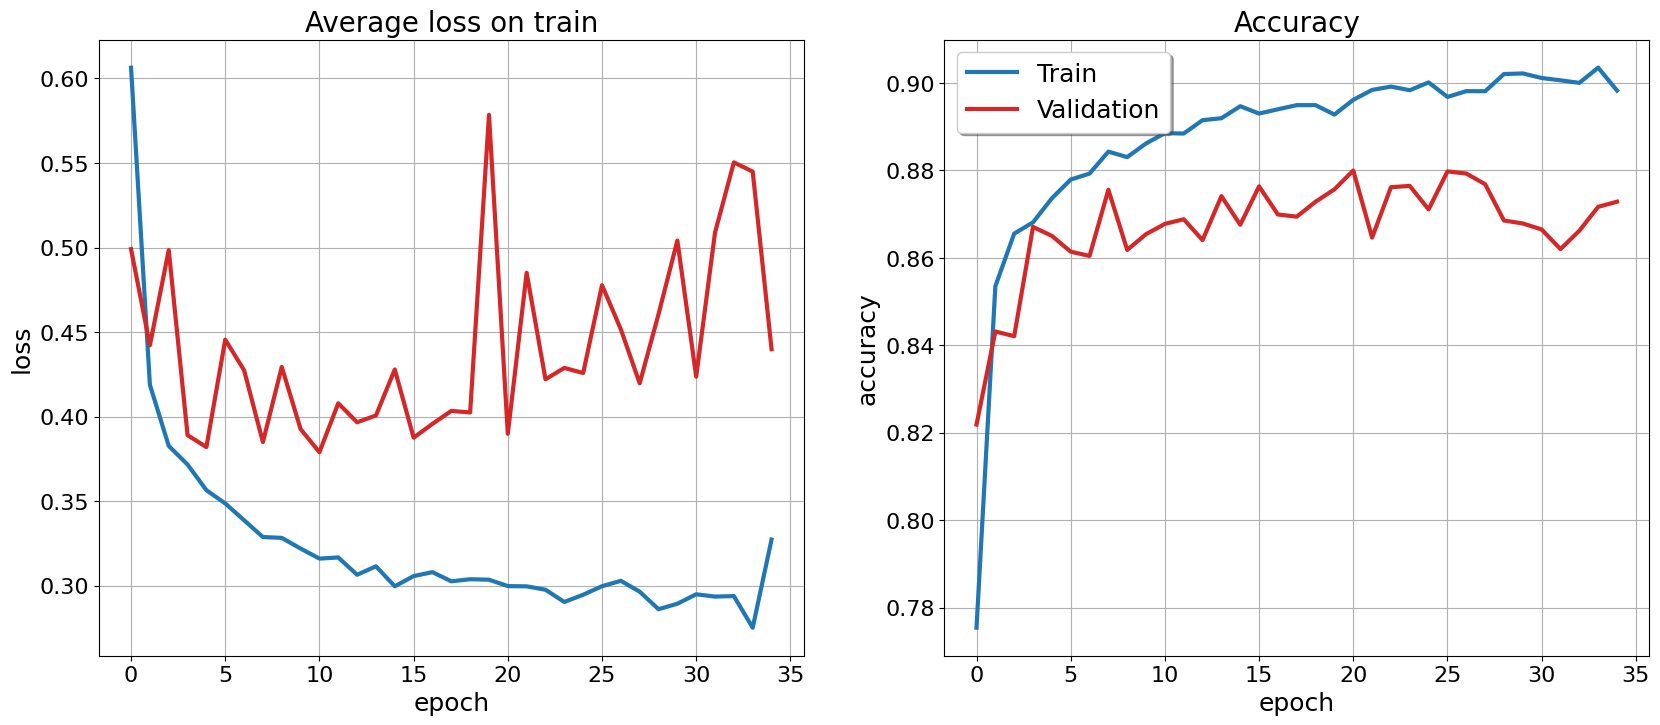

In [ ]:

plot_results(loss_history, loss_val_history, train_acc_history, val_acc_history)


In [ ]:
test_accuracy(overfit_model)



Test accuracy 0.8728515625


По графику видно что loss на трейне продолжает падать, в то время как на валидации начинает сильно возрастать, при этом accuracy на трейне растет, а на валидации падает, при этом на тесте мы получаем результат хуже предыдущей нейронки. Получили переобучение.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

Постараемся избавится от переобучения за счет классических методов регулеризации. Добавим после каждого слоя batchnorm и dropout. Откидывать связи при помощи dropout будем все меньше по мере продвижения по слоям.

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 600),
            nn.BatchNorm1d(600),
            nn.Dropout(p=0.6),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(400, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out


In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 600]         471,000
       BatchNorm1d-3                  [-1, 600]           1,200
           Dropout-4                  [-1, 600]               0
              ReLU-5                  [-1, 600]               0
            Linear-6                  [-1, 400]         240,400
       BatchNorm1d-7                  [-1, 400]             800
              ReLU-8                  [-1, 400]               0
           Dropout-9                  [-1, 400]               0
           Linear-10                  [-1, 128]          51,328
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [ ]:
fixed_model = FixedNeuralNetwork().to(device)
opt = optim.Adam(fixed_model.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss().type(torch.FloatTensor) # YOUR CODE HERE
#loss_func = nn.NLLLoss()
# Your experiments, come here

num_epochs = 20
loss_history, loss_val_history, train_acc_history, val_acc_history = train_model(fixed_model,
                                                       train_loader,
                                                       test_loader,
                                                       loss_func,
                                                       opt,
                                                       num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Average loss: 0.7227960824966431, Train accuracy: 0.7452303216062544, Val accuracy: 0.8236328125
---------------------------------------------------------------------------
Epoch 2/20
Average loss: 0.5444862842559814, Train accuracy: 0.8151985607675906, Val accuracy: 0.8494140625
---------------------------------------------------------------------------
Epoch 3/20
Average loss: 0.4956982433795929, Train accuracy: 0.8307791400142147, Val accuracy: 0.8513671875
---------------------------------------------------------------------------
Epoch 4/20
Average loss: 0.46457910537719727, Train accuracy: 0.8413623845060412, Val accuracy: 0.85732421875
---------------------------------------------------------------------------
Epoch 5/20
Average loss: 0.4420889616012573, Train accuracy: 0.8486362828713575, Val accuracy: 0.86640625
---------------------------------------------------------------------------
Epoch 6/20
Average loss: 0.42531511187553406, Train accuracy: 0.8551550284292821

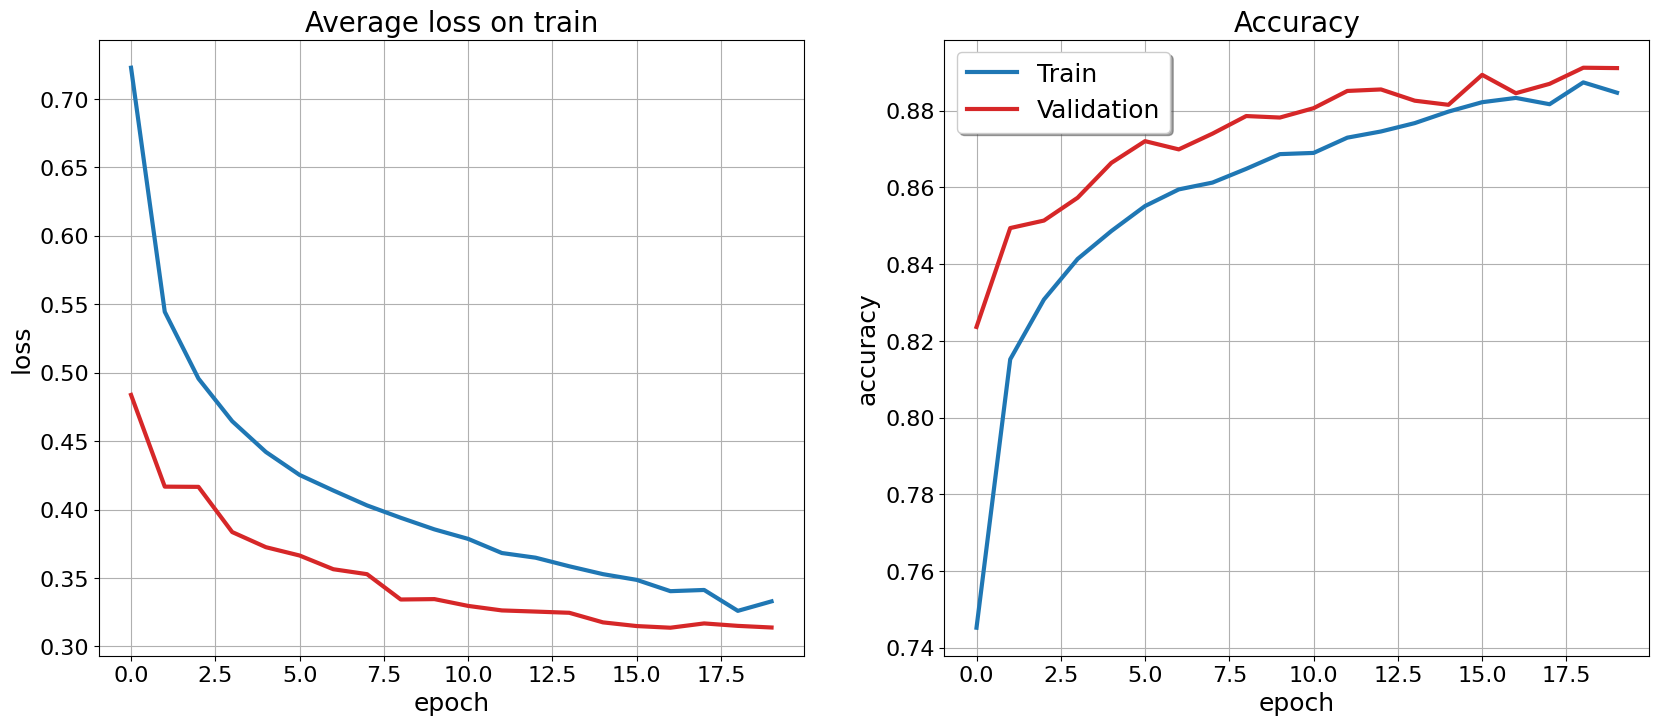

In [ ]:

plot_results(loss_history, loss_val_history, train_acc_history, val_acc_history)


Тут получились несколько аномальные результаты, что на train loss выше чем на валидации, однако по графикам можно сказать что мы избавились от переобучения, так же выросла метрика. Однако попробуем добавить эпох и уменьшить параметр p для dropout, посмотрим что произойдет.

In [ ]:
test_accuracy(fixed_model)


In [ ]:
class FixedNeuralNetwork_2(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 600),
            nn.BatchNorm1d(600),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(400, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(32, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Average loss: 0.6355082988739014, Train accuracy: 0.7780961265103056, Val accuracy: 0.84697265625
---------------------------------------------------------------------------
Epoch 2/20
Average loss: 0.4834650754928589, Train accuracy: 0.8327114427860697, Val accuracy: 0.84580078125
---------------------------------------------------------------------------
Epoch 3/20
Average loss: 0.43913188576698303, Train accuracy: 0.8478422619047619, Val accuracy: 0.858984375
---------------------------------------------------------------------------
Epoch 4/20
Average loss: 0.41026318073272705, Train accuracy: 0.8571761727078892, Val accuracy: 0.87451171875
---------------------------------------------------------------------------
Epoch 5/20
Average loss: 0.38758665323257446, Train accuracy: 0.8640502842928216, Val accuracy: 0.869140625
---------------------------------------------------------------------------
Epoch 6/20
Average loss: 0.37548625469207764, Train accuracy: 0.869247512437

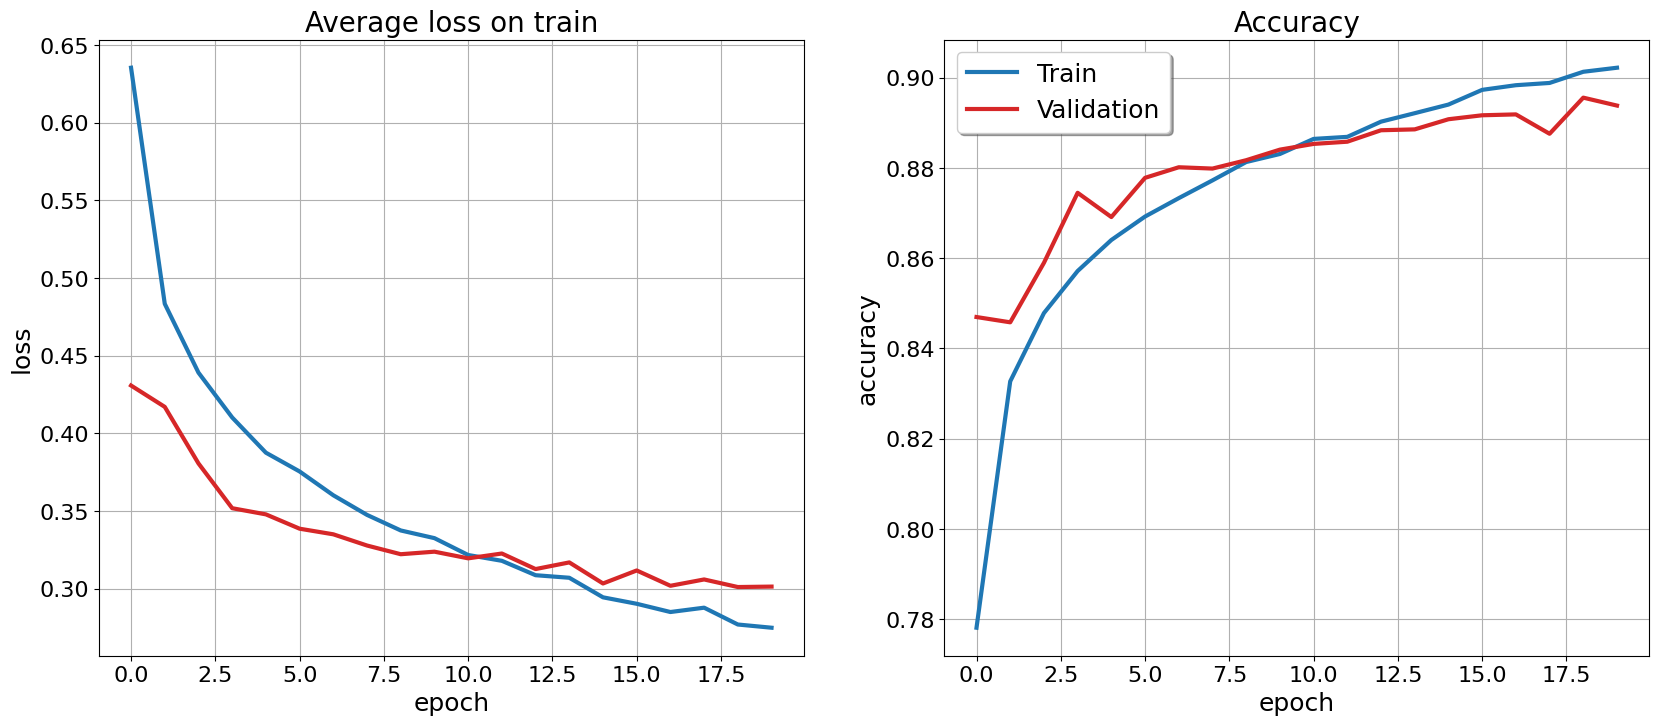


Test accuracy 0.8728515625


In [ ]:
fixed_model = FixedNeuralNetwork_2().to(device)
opt = optim.Adam(fixed_model.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss().type(torch.FloatTensor) # YOUR CODE HERE
#loss_func = nn.NLLLoss()
# Your experiments, come here

num_epochs = 20
loss_history, loss_val_history, train_acc_history, val_acc_history = train_model(fixed_model,
                                                       train_loader,
                                                       test_loader,
                                                       loss_func,
                                                       opt,
                                                       num_epochs)

plot_results(loss_history, loss_val_history, train_acc_history, val_acc_history)


In [ ]:
test_accuracy(fixed_model)



Test accuracy 0.89384765625


Заметно что после 10 эпохи train и val поменялись местами в loss, а на 10 эпохе это произошло и на метрике.Однако переобучения нет, и метрика на тесте так же больше изначальных моделей

### Conclusions:
_Write down small report with your conclusions and your ideas._

В данной части лабы мы еще раз убедились в важности использования методов регуляризации batchnorm и dropout. Проблема переобучения одна из основных проблем в машинном обучении и в данной работе мы лучше с ней познакомились. Можно сделать выводы, что нужно искать баланс в глубине нейронок, точности и скорости обучения. Batchnorm и dropout отлично работают вместе и позволяют улучшать score без боязни переобучения.